In [1]:
import argparse
import json
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import tf
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
import os
import csv
import cv2
from nerf_vision_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Get relative path to the current file
PATH = os.getcwd()
print(PATH)
CONGIG_PATH = os.path.join(PATH, '../json/jackal.json')

#Read the config file as a json
move_base_frame = ""
camera_topic = ""
camere_frame = ""
robot_frame = ""

with open(CONGIG_PATH) as f:
    config_dict = json.load(f)
    camera_topic = config_dict["camera_topic"]
    camera_frame = config_dict["camera_frame"]
    robot_frame = config_dict["robot_frame"]
    move_base_frame = config_dict["move_base_frame"]
print("Camera Topic:", camera_topic)
print("Camera Frame:", camera_frame)
print("Robot Frame:", robot_frame)
print("Move Base Frame:", move_base_frame)

#Read the coordinates file as a csv
COORDINATES_PATH = os.path.join(PATH, '../targets/square.csv')
coordinates = []
with open(COORDINATES_PATH) as f:
    reader = csv.reader(f)
    for row in reader:
        #Convert the string to float
        row = [float(i) for i in row]
        coordinates.append(row)
print(coordinates)

SAVE_PATH = os.path.join(PATH, '../data/square')
print("Save Path:", SAVE_PATH)
#Create the save path if it does not exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


/home/boomalope2/nerf_estimator/src/nerf_vision/scripts
Camera Topic: /camera/camera1/image_raw
Camera Frame: camera_link_optical
Robot Frame: base_link
Move Base Frame: world
[[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [2.0, 2.0, 0.0], [0.0, 2.0, 0.0]]
Save Path: /home/boomalope2/nerf_estimator/src/nerf_vision/scripts/../data/square


In [3]:
rospy.init_node('data_collection')

#Initialize the odom injector
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()

current_camera_img = None
#Initialize the camera subscriber
def callback(data):
    global current_camera_img
    cv_image = getCameraTopicAsCvImage(data)
    #Convert the image to BGR
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR)
    current_camera_img = cv_image
# Subscribe to the camera topic
rospy.Subscriber(camera_topic, Image, callback)

Going to:  [0.0, 0.0, 0.0]


Reached:  [0.0, 0.0, 0.0]
xyz:  [0.003025614182065688, -1.4146283942030091, -1.4137979509038956]
rpy:  (-0.7422654270279755, -0.2867253496722267, -0.29902600771637)


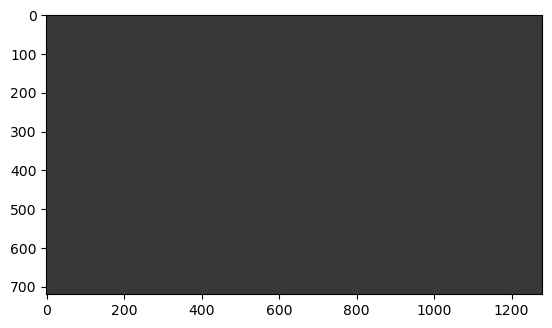

Going to:  [2.0, 0.0, 0.0]
Reached:  [2.0, 0.0, 0.0]
xyz:  [1.549123752797219, -2.004795990413926, -0.8231954988505683]
rpy:  (-0.7104018838868161, -0.37001998679766135, -0.3981025646317474)


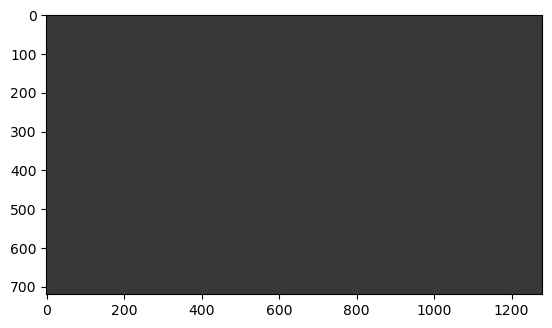

Going to:  [2.0, 2.0, 0.0]
Reached:  [2.0, 2.0, 0.0]
xyz:  [2.70086018263776, -1.0494818830282207, -1.7780057325528407]
rpy:  (-0.7409011578420067, -0.2911513106003898, -0.3039605805135877)


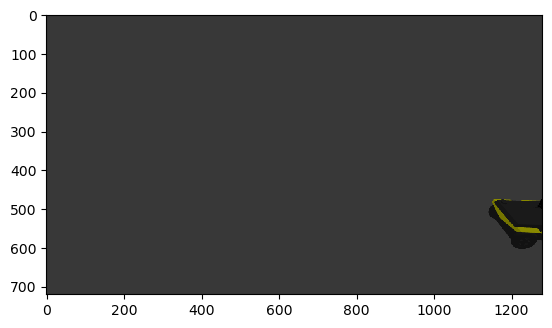

Going to:  [0.0, 2.0, 0.0]
Reached:  [0.0, 2.0, 0.0]
xyz:  [1.1233692013789465, -0.33214563297196387, -2.4947857825340476]
rpy:  (-0.7484874628701048, -0.26664606231071725, -0.27665915527493323)


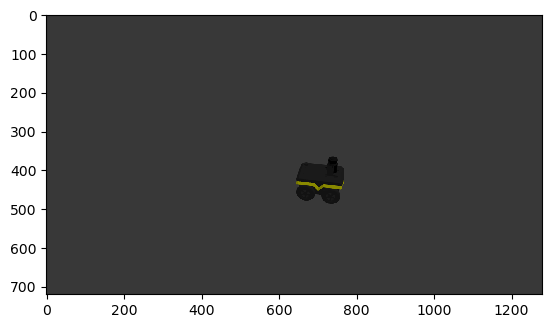

In [4]:
#Iterate through coordiates, capturing a picture and pose once arriving at each coordinate
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()
for i, c in enumerate(coordinates):
    print("Going to: ", c)
    
    #Navigate to goal
    goal = getMoveBaseGoal(move_base_frame, c[0], c[1], c[2])
    client.send_goal(goal)
    client.wait_for_result()
    print("Reached: ", c)

    #Calculate relative pose
    xyz, rpy = getRobotPose(camera_frame, robot_frame)
    print("xyz: ", xyz)
    print("rpy: ", rpy)

    #Capture image
    plt.imshow(current_camera_img)
    plt.show()

    #Save image and pose
    img_name = str(i) + '.png'
    pose_name = str(i) + '.txt'
    img_path = os.path.join(SAVE_PATH, img_name)
    pose_path = os.path.join(SAVE_PATH, pose_name)
    cv2.imwrite(img_path, current_camera_img)
    with open(pose_path, 'w') as f:
        f.write(str(xyz[0]) + ', ' + str(xyz[1]) + ', ' + str(xyz[2]) + ', ' + str(rpy[0]) + ', ' + str(rpy[1]) + ', ' + str(rpy[2]))